In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [102]:
df = pd.read_csv('/content/vehicles.csv')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15404 entries, 0 to 15403
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            15404 non-null  int64  
 1   url           15404 non-null  object 
 2   region        15404 non-null  object 
 3   region_url    15404 non-null  object 
 4   price         15404 non-null  int64  
 5   year          15374 non-null  float64
 6   manufacturer  14554 non-null  object 
 7   model         15213 non-null  object 
 8   condition     8535 non-null   object 
 9   cylinders     9499 non-null   object 
 10  fuel          15346 non-null  object 
 11  odometer      12656 non-null  float64
 12  title_status  15340 non-null  object 
 13  transmission  15353 non-null  object 
 14  vin           8267 non-null   object 
 15  drive         10973 non-null  object 
 16  size          4965 non-null   object 
 17  type          10978 non-null  object 
 18  paint_color   10173 non-nu

In [104]:
df.describe()

,id,price,year,odometer,county,lat,long
count,1.540400e+04,1.540400e+04,15374.000000,1.265600e+04,0.0,15146.000000,15146.000000
mean,7.116275e+09,1.332109e+04,2009.874789,1.011182e+05,NaN,38.211050,-94.113428
std,4.906640e+06,8.172692e+04,9.049205,1.620128e+05,NaN,6.324423,18.218389
min,7.096577e+09,0.000000e+00,1913.000000,0.000000e+00,NaN,-51.300000,-124.284000
25%,7.113323e+09,4.900750e+03,2007.000000,4.609900e+04,NaN,33.779200,-114.013500
50%,7.117174e+09,9.952000e+03,2012.000000,9.034800e+04,NaN,38.017950,-85.281550
75%,7.120854e+09,1.749800e+04,2015.000000,1.339415e+05,NaN,43.921900,-80.359200
max,7.121601e+09,1.000000e+07,2021.000000,9.999999e+06,NaN,48.902800,-2.629330


In [133]:
df_clean = df.copy()

# Drop irrelevant columns
df_clean = df_clean.drop(columns=['id', 'url', 'region_url'])

In [134]:
Q1 = df_clean['price'].quantile(0.05)
Q3 = df_clean['price'].quantile(0.95)
IQR = Q3 - Q1
price_lower_bound = Q1 - 1.5 * IQR
price_upper_bound = Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean['price'] >= max(500, price_lower_bound)) &
                    (df_clean['price'] <= min(100000, price_upper_bound))]

In [135]:
df_clean['price_log'] = np.log1p(df_clean['price'])

# Enhanced year handling
df_clean = df_clean[(df_clean['year'] >= 1975) & (df_clean['year'] <= 2021)]
df_clean['age'] = 2020 - df_clean['year']
df_clean['age_squared'] = df_clean['age'] ** 2
df_clean = df_clean.drop(columns=['year'])

In [136]:
cat_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders']
for col in cat_columns:
    if df_clean[col].isnull().mean() > 0.3:  # If more than 30% missing
        df_clean[col].fillna('unknown', inplace=True)
    else:
        # Fill with mode for columns with less missing data
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)

In [137]:
manufacturer_counts = df_clean['manufacturer'].value_counts()
manufacturer_price_avg = df_clean.groupby('manufacturer')['price'].mean()
df_clean['manufacturer_tier'] = pd.qcut(manufacturer_price_avg, 4, labels=['economy', 'mid_range', 'premium', 'luxury'])
df_clean['manufacturer'] = df_clean['manufacturer'].apply(
    lambda x: x if manufacturer_counts[x] > 200 else 'other_make'
)

In [138]:
model_counts = df_clean['model'].value_counts()
df_clean['is_common_model'] = df_clean['model'].isin(model_counts.head(100).index).astype(int)
df_clean['model_length'] = df_clean['model'].str.len()
df_clean = df_clean.drop(columns=['model'])

In [139]:
cylinder_map = {
    'unknown': 0, 'other': 0, '3 cylinders': 3, '4 cylinders': 4,
    '5 cylinders': 5, '6 cylinders': 6, '8 cylinders': 8,
    '10 cylinders': 10, '12 cylinders': 12
}
df_clean['cylinder_count'] = df_clean['cylinders'].map(cylinder_map)
df_clean['has_high_cylinders'] = (df_clean['cylinder_count'] >= 6).astype(int)
df_clean = df_clean.drop(columns=['cylinders'])

In [140]:
df_clean['age_cylinders'] = df_clean['age'] * df_clean['cylinder_count']
df_clean['luxury_condition'] = (df_clean['manufacturer_tier'].isin(['premium', 'luxury'])) & \
                              (df_clean['condition'].isin(['excellent', 'like new']))

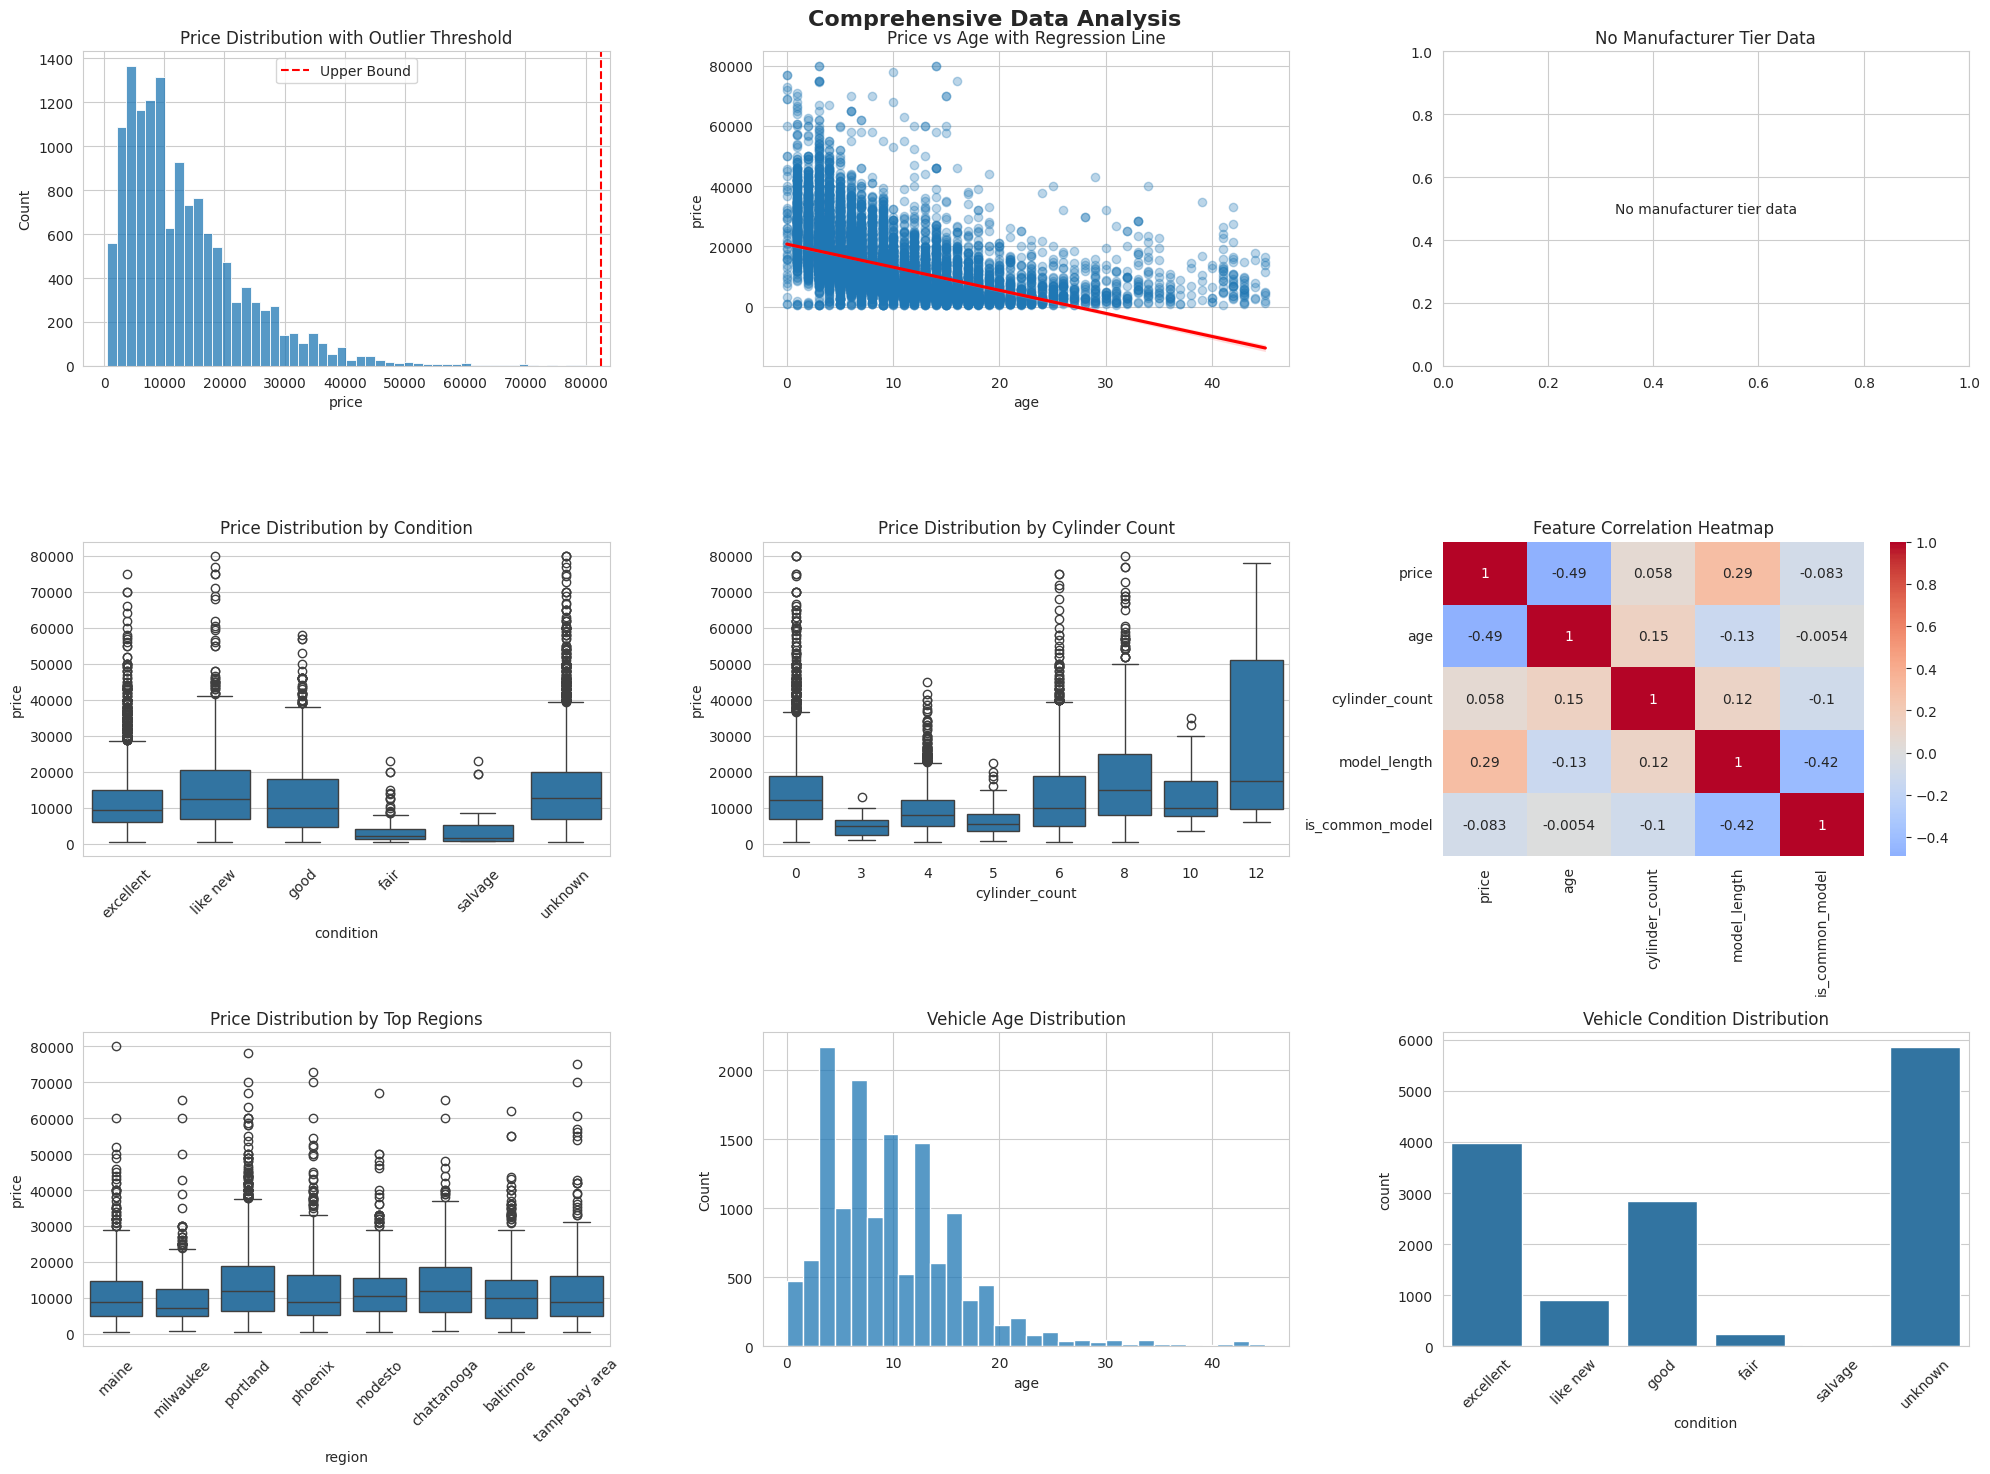

In [144]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Comprehensive Data Analysis', fontsize=16, fontweight='bold')

# 1. Price distribution with outliers highlighted
sns.histplot(df_clean['price'], bins=50, ax=axes[0, 0])
axes[0, 0].axvline(price_upper_bound, color='red', linestyle='--', label='Upper Bound')
axes[0, 0].set_title('Price Distribution with Outlier Threshold')
axes[0, 0].legend()

# 2. Price vs Age with regression line
sns.regplot(x='age', y='price', data=df_clean, ax=axes[0, 1], scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
axes[0, 1].set_title('Price vs Age with Regression Line')

# 3. Price by Manufacturer Tier - FIXED
valid_tiers = df_clean['manufacturer_tier'].dropna().unique()
if len(valid_tiers) > 0:
    sns.boxplot(x='manufacturer_tier', y='price', data=df_clean[df_clean['manufacturer_tier'].isin(valid_tiers)], ax=axes[0, 2])
    axes[0, 2].set_title('Price Distribution by Manufacturer Tier')
    axes[0, 2].tick_params(axis='x', rotation=45)
else:
    axes[0, 2].text(0.5, 0.5, 'No manufacturer tier data', ha='center', va='center')
    axes[0, 2].set_title('No Manufacturer Tier Data')

# 4. Price by Condition
condition_order = ['excellent', 'like new', 'good', 'fair', 'salvage', 'unknown']
df_clean['condition'] = pd.Categorical(df_clean['condition'], categories=condition_order, ordered=True)
sns.boxplot(x='condition', y='price', data=df_clean, ax=axes[1, 0])
axes[1, 0].set_title('Price Distribution by Condition')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Price by Cylinder Count
sns.boxplot(x='cylinder_count', y='price', data=df_clean, ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution by Cylinder Count')

# 6. Correlation heatmap
corr_features = ['price', 'age', 'cylinder_count', 'model_length', 'is_common_model']
corr_matrix = df_clean[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Heatmap')

# 7. Price distribution by region (top 8 regions)
top_regions = df_clean['region'].value_counts().head(8).index
region_data = df_clean[df_clean['region'].isin(top_regions)]
sns.boxplot(x='region', y='price', data=region_data, ax=axes[2, 0])
axes[2, 0].set_title('Price Distribution by Top Regions')
axes[2, 0].tick_params(axis='x', rotation=45)

# 8. Age distribution
sns.histplot(df_clean['age'], bins=30, ax=axes[2, 1])
axes[2, 1].set_title('Vehicle Age Distribution')

# 9. Condition distribution
sns.countplot(x='condition', data=df_clean, ax=axes[2, 2])
axes[2, 2].set_title('Vehicle Condition Distribution')
axes[2, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

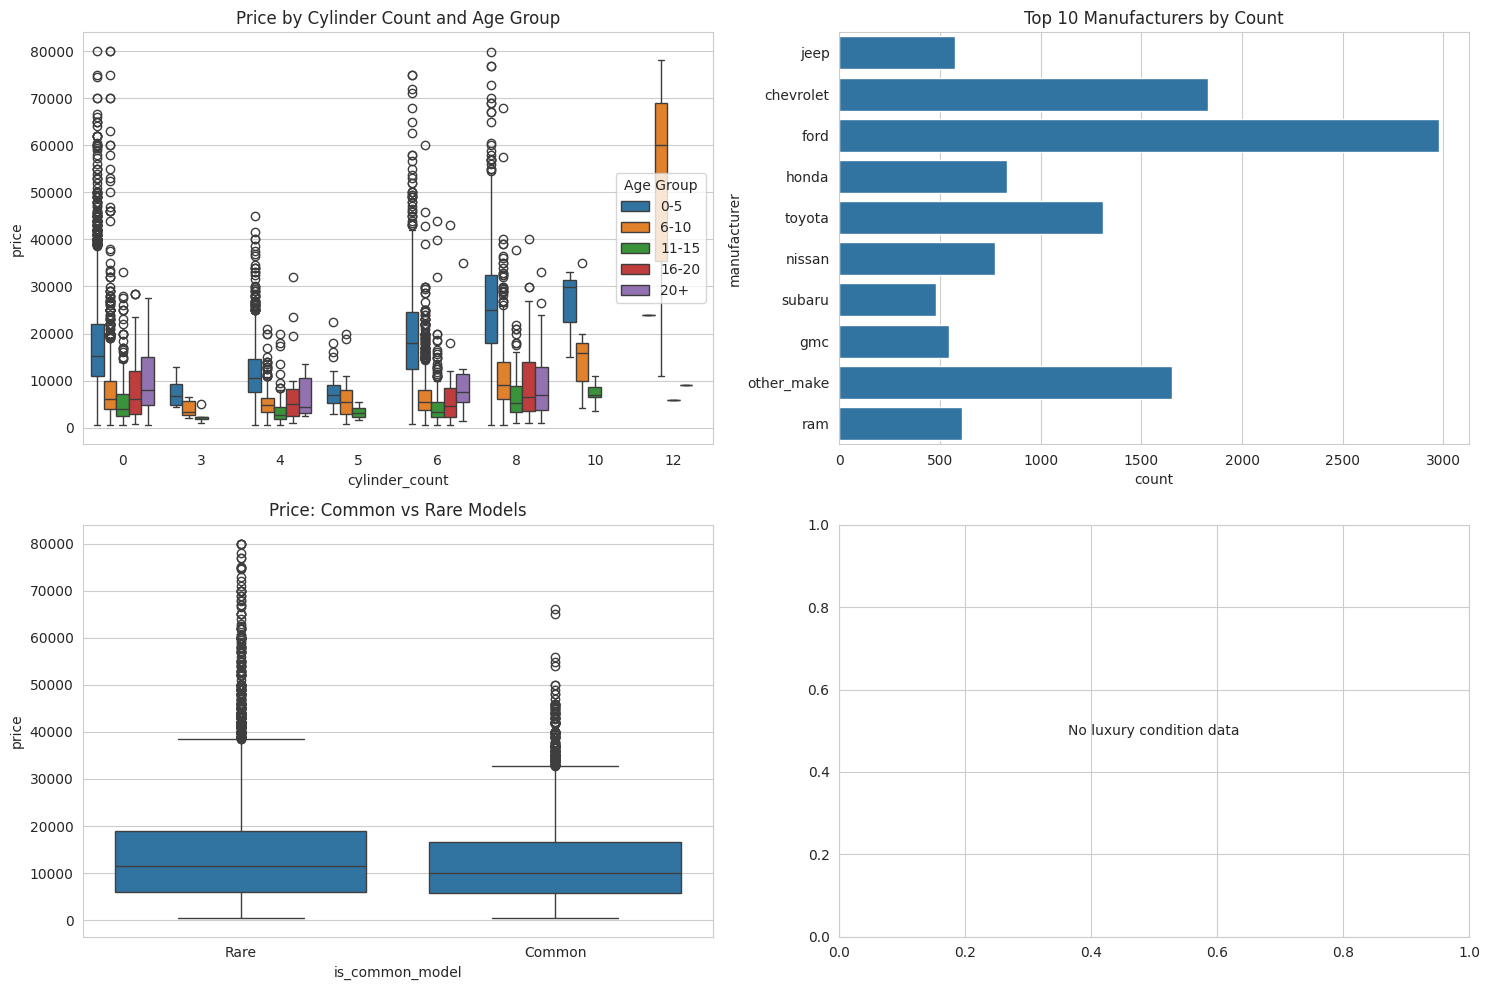

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price vs Cylinder count by age group
df_clean['age_group'] = pd.cut(df_clean['age'], bins=5, labels=['0-5', '6-10', '11-15', '16-20', '20+'])
sns.boxplot(x='cylinder_count', y='price', hue='age_group', data=df_clean, ax=axes[0, 0])
axes[0, 0].set_title('Price by Cylinder Count and Age Group')
axes[0, 0].legend(title='Age Group')

# Manufacturer distribution
top_10_manufacturers = df_clean['manufacturer'].value_counts().head(10).index
manufacturer_data = df_clean[df_clean['manufacturer'].isin(top_10_manufacturers)]
sns.countplot(y='manufacturer', data=manufacturer_data, ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Manufacturers by Count')

# Price distribution by common vs rare models
sns.boxplot(x='is_common_model', y='price', data=df_clean, ax=axes[1, 0])
axes[1, 0].set_title('Price: Common vs Rare Models')
axes[1, 0].set_xticklabels(['Rare', 'Common'])

# Luxury condition analysis
luxury_data = df_clean[df_clean['luxury_condition'] == 1]
if not luxury_data.empty:
    sns.boxplot(x='manufacturer_tier', y='price', data=luxury_data, ax=axes[1, 1])
    axes[1, 1].set_title('Luxury Vehicles in Excellent Condition')
else:
    axes[1, 1].text(0.5, 0.5, 'No luxury condition data', ha='center', va='center')

plt.tight_layout()
plt.show()

In [146]:
X = df_clean.drop(columns=['price', 'price_log', 'manufacturer_tier', 'age_group'])
y = df_clean['price_log']
y_actual = df_clean['price']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_act_train, y_act_test = train_test_split(X, y_actual, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (11131, 26)
Test data shape: (2783, 26)


In [148]:
numeric_features = ['age', 'age_squared', 'cylinder_count', 'model_length', 'age_cylinders']
categorical_features = ['region', 'manufacturer', 'condition']
binary_features = ['is_common_model', 'has_high_cylinders', 'luxury_condition']

In [149]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features)
    ])

In [151]:
try:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
        ('regressor', XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse'))
    ])

    param_dist = {
        'regressor__n_estimators': stats.randint(200, 600),
        'regressor__learning_rate': stats.uniform(0.01, 0.2),
        'regressor__max_depth': stats.randint(4, 10),
        'regressor__subsample': stats.uniform(0.7, 0.3),
        'regressor__colsample_bytree': stats.uniform(0.7, 0.3),
    }

    search = RandomizedSearchCV(
        pipeline,
        param_dist,
        n_iter=15,
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print("Model training completed successfully!")

except Exception as e:
    print(f"Error during model training: {e}")
    print("Using simpler model as fallback...")
    # Fallback to simpler model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
    ])
    pipeline.fit(X_train, y_train)
    best_model = pipeline

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Model training completed successfully!


In [153]:
# Make predictions
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [154]:
# Calculate metrics
mse = mean_squared_error(y_act_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_act_test, y_pred)
r2 = r2_score(y_act_test, y_pred)

In [155]:
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Percentage Error: {(mae / y_act_test.mean()) * 100:.1f}%")

RMSE: $5961.42
MAE: $3676.84
R²: 0.6448
Percentage Error: 27.5%


In [156]:
results_df = X_test.copy()
results_df['actual_price'] = y_act_test.values
results_df['predicted_price'] = y_pred
results_df['residual'] = results_df['actual_price'] - results_df['predicted_price']
results_df['abs_residual'] = np.abs(results_df['residual'])
results_df['residual_percentage'] = (results_df['residual'] / results_df['actual_price']) * 100


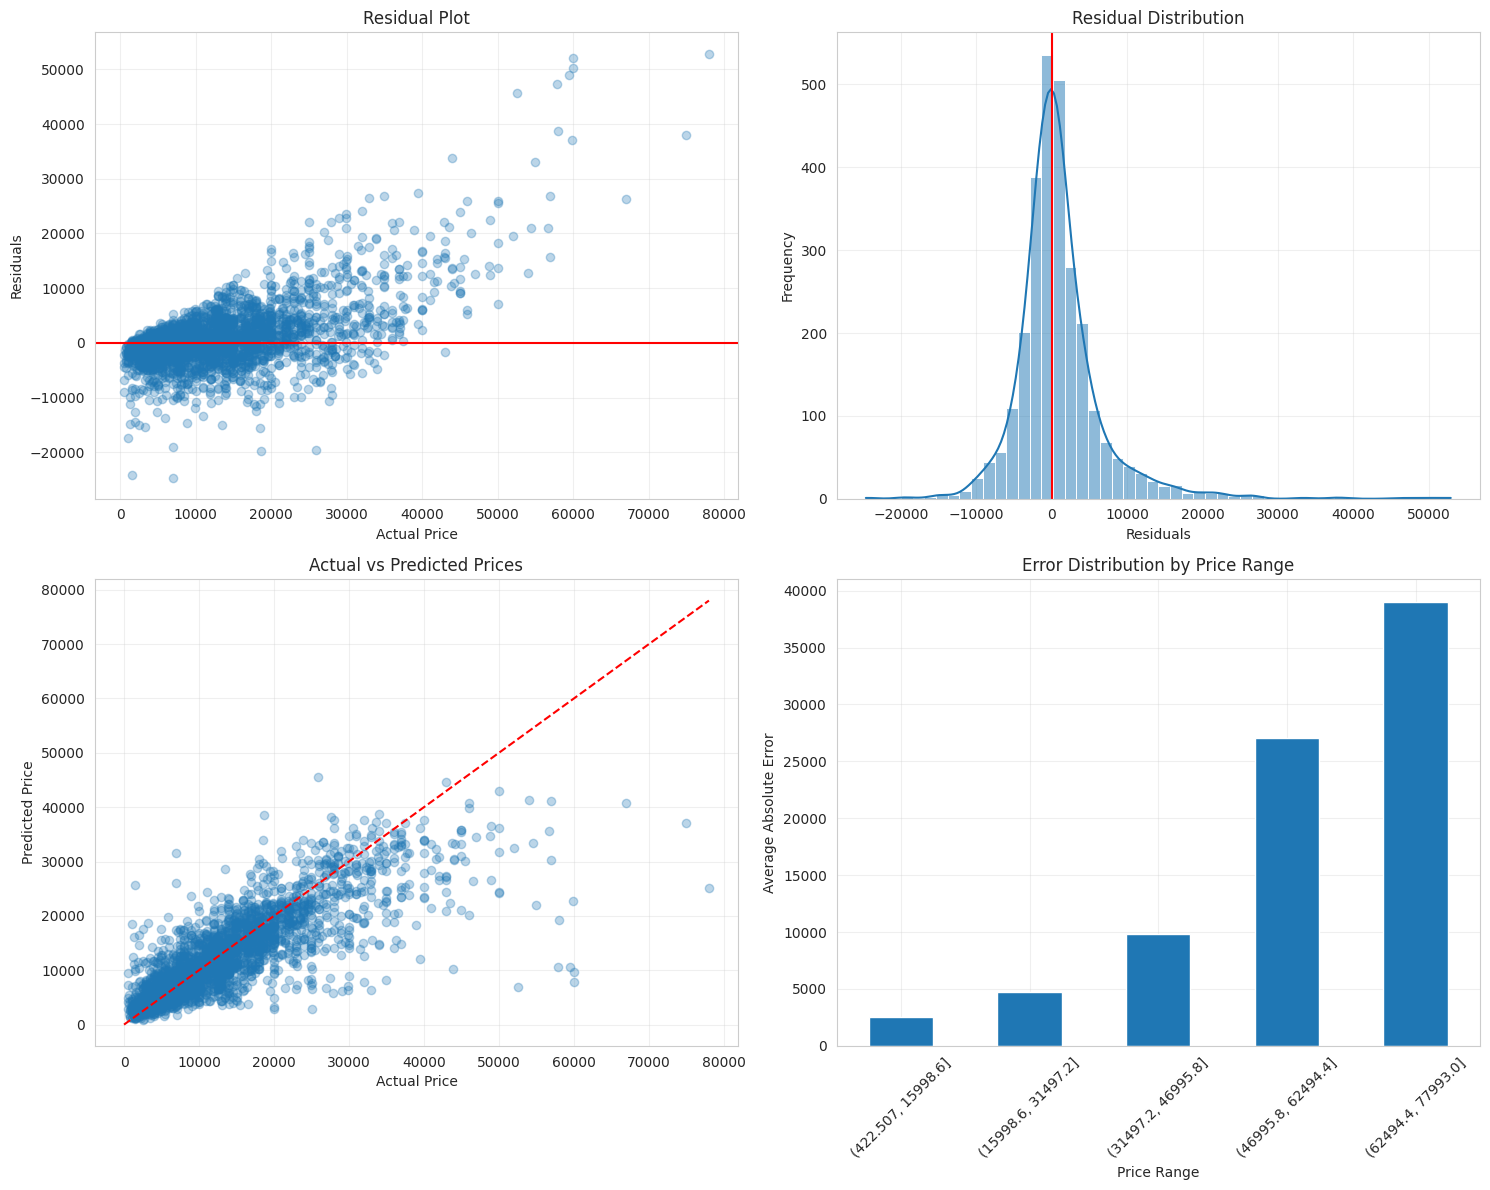

In [157]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residual plot
axes[0, 0].scatter(results_df['actual_price'], results_df['residual'], alpha=0.3)
axes[0, 0].axhline(y=0, color='r', linestyle='-')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot')
axes[0, 0].grid(True, alpha=0.3)

# Residual distribution
sns.histplot(results_df['residual'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].axvline(x=0, color='r', linestyle='-')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)
# Actual vs Predicted
max_val = max(results_df['actual_price'].max(), results_df['predicted_price'].max())
axes[1, 0].scatter(results_df['actual_price'], results_df['predicted_price'], alpha=0.3)
axes[1, 0].plot([0, max_val], [0, max_val], 'r--')
axes[1, 0].set_xlabel('Actual Price')
axes[1, 0].set_ylabel('Predicted Price')
axes[1, 0].set_title('Actual vs Predicted Prices')
axes[1, 0].grid(True, alpha=0.3)

# Error distribution by price range
results_df['price_bin'] = pd.cut(results_df['actual_price'], bins=5)
error_by_bin = results_df.groupby('price_bin')['abs_residual'].mean()
error_by_bin.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Price Range')
axes[1, 1].set_ylabel('Average Absolute Error')
axes[1, 1].set_title('Error Distribution by Price Range')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [158]:
print("\nPerformance by Price Segment:")
results_df['price_segment'] = pd.cut(results_df['actual_price'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
segment_performance = results_df.groupby('price_segment').agg({
    'actual_price': 'count',
    'residual': 'mean',
    'abs_residual': 'mean',
    'residual_percentage': 'mean'
}).round(2)

print(segment_performance)


Performance by Price Segment:
               actual_price  residual  abs_residual  residual_percentage
price_segment                                                           
Very Low               1930   -606.92       2522.61               -26.34
Low                     683   2470.62       4695.89                10.50
Medium                  144   9447.22       9846.69                25.16
High                     23  27028.17      27028.17                49.09
Very High                 3  39045.19      39045.19                52.56


In [159]:
print("\nSample Predictions:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
for i, idx in enumerate(sample_indices):
    actual = results_df.iloc[idx]['actual_price']
    predicted = results_df.iloc[idx]['predicted_price']
    error = actual - predicted
    error_percent = (error / actual) * 100

    print(f"\nSample {i+1}:")
    print(f"  Manufacturer: {results_df.iloc[idx]['manufacturer']}")
    print(f"  Condition: {results_df.iloc[idx]['condition']}")
    print(f"  Age: {results_df.iloc[idx]['age']} years")
    print(f"  Cylinders: {results_df.iloc[idx]['cylinder_count']}")
    print(f"  Actual: ${actual:,.2f}")
    print(f"  Predicted: ${predicted:,.2f}")
    print(f"  Error: ${error:,.2f} ({error_percent:+.1f}%)")


Sample Predictions:

Sample 1:
  Manufacturer: ford
  Condition: excellent
  Age: 14.0 years
  Cylinders: 8
  Actual: $14,000.00
  Predicted: $9,518.92
  Error: $4,481.08 (+32.0%)

Sample 2:
  Manufacturer: nissan
  Condition: excellent
  Age: 14.0 years
  Cylinders: 6
  Actual: $5,990.00
  Predicted: $4,672.10
  Error: $1,317.90 (+22.0%)

Sample 3:
  Manufacturer: chevrolet
  Condition: excellent
  Age: 28.0 years
  Cylinders: 8
  Actual: $4,250.00
  Predicted: $5,704.62
  Error: $-1,454.62 (-34.2%)

Sample 4:
  Manufacturer: toyota
  Condition: unknown
  Age: 6.0 years
  Cylinders: 0
  Actual: $26,460.00
  Predicted: $16,318.67
  Error: $10,141.33 (+38.3%)

Sample 5:
  Manufacturer: mercedes-benz
  Condition: good
  Age: 10.0 years
  Cylinders: 6
  Actual: $10,900.00
  Predicted: $11,204.46
  Error: $-304.46 (-2.8%)


In [160]:
print(f"\nModel Performance Summary:")
print(f"Average Error: ${results_df['abs_residual'].mean():.2f}")
print(f"Median Error: ${results_df['abs_residual'].median():.2f}")
print(f"95% within: ${results_df['abs_residual'].quantile(0.95):.2f}")
print(f"R² Score: {r2:.4f}")


Model Performance Summary:
Average Error: $3676.84
Median Error: $2234.15
95% within: $11888.42
R² Score: 0.6448
